<a href="https://colab.research.google.com/github/GhosterUser31/DavidAngel/blob/main/IllusionDiffusionQW_%F0%9F%8C%80%F0%9F%A7%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# @title Installs

!pip install torch torchvision diffusers transformers ipywidgets
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:

# @title Imports and load models

import torch
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    AutoencoderKL,
    StableDiffusionLatentUpscalePipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionControlNetImg2ImgPipeline,
)
from transformers import CLIPImageProcessor
from PIL import Image
import random
import os
import time

# Configuración del modelo base
BASE_MODEL = "SG161222/Realistic_Vision_V5.1_noVAE"

# Cargar modelos
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)

# Safety checker
SAFETY_CHECKER_ENABLED = os.environ.get("SAFETY_CHECKER", "0") == "1"
safety_checker = None
feature_extractor = None
if SAFETY_CHECKER_ENABLED:
    safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker").to("cuda")
    feature_extractor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Pipeline principal
main_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor,
    torch_dtype=torch.float16,
).to("cuda")

# Pipeline de Img2Img
image_pipe = StableDiffusionControlNetImg2ImgPipeline(**main_pipe.components)

In [3]:
# @title Add Moddified

# Mapa de samplers
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

# Función para recortar y redimensionar la imagen
def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size
    new_dimension = min(width, height)
    left = (width - new_dimension)/2
    top = (height - new_dimension)/2
    right = (width + new_dimension)/2
    bottom = (height + new_dimension)/2
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)
    return img

# Función de inferencia
def inference(
    control_image: Image.Image,
    prompt: str,
    negative_prompt: str,
    guidance_scale: float = 8.0,
    controlnet_conditioning_scale: float = 1,
    seed: int = -1,
    sampler: str = "DPM++ Karras SDE"
):
    # Redimensionar imagen
    control_image_small = center_crop_resize(control_image)
    control_image_large = center_crop_resize(control_image, (1024, 1024))

    # Establecer el generador de semilla
    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device="cuda").manual_seed(my_seed)

    # Realizar inferencia
    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)
    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image_small,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        num_inference_steps=15,
        output_type="latent"
    )

    # Upscaling de la imagen
    upscaled_latents = upscale(out, "nearest-exact", 2)
    out_image = image_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        control_image=control_image_large,
        image=upscaled_latents,
        guidance_scale=guidance_scale,
        generator=generator,
        num_inference_steps=20,
        strength=1,
        controlnet_conditioning_scale=controlnet_conditioning_scale
    )

    return out_image["images"][0]

In [6]:
# @title 𝗚𝗨𝗜 𝗤𝗪©

# This code will be hidden when the notebook is loaded.


import torch
from io import BytesIO
from PIL import Image
import random
from diffusers import (
    AutoencoderKL,
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    StableDiffusionControlNetImg2ImgPipeline,
    DPMSolverMultistepScheduler,
    EulerDiscreteScheduler,
)
import os
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, HTML, Image as IPImage

# Fondo y estilos en HTML
custom_styles = """
<style>
/* Fondo personalizado */
body {
    background: url('https://w0.peakpx.com/wallpaper/246/10/HD-wallpaper-the-notorious-big-2020-biggie-hip-hop-rap-romania-smalls-tupac-usa.jpg') no-repeat center center fixed;
    background-size: cover;
    color: #00FF00;
}

/* Título animado multicolor */
h3 {
  font-family: inherit;
  font-size: 30px;
  text-shadow: 0px 2px 4px black;
  opacity: 0.99;
  background-image: url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: move 160s linear infinite;
}

/* Nombres de ajustes con animación */
h2 {
  font-family: inherit;
  font-size: 10px;
  text-shadow: 0px 2px 4px black;
  opacity: 0.9;
  background-image: url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: move 120s linear infinite;
}

/* Animación del fondo multicolor */
@keyframes move {
  to {
    background-position: 4500vh;
  }
}

/* Botones redondeados con animación tóxica */
button {
  font-family: inherit;
  font-size: 14px;
  border: 2px solid rgba(0, 255, 0, 0.6); /* Contorno verde translúcido */
  background-color: rgba(0, 0, 0, 0.8); /* Fondo negro translúcido */
  color: #00FF00;
  border-radius: 15px; /* Bordes redondeados */
  padding: 5px 10px;
  box-shadow: 0px 0px 10px rgba(0, 255, 0, 0.6); /* Efecto de brillo */
  transition: all 0.3s ease-in-out;
}

button:hover {
  box-shadow: 0px 0px 20px rgba(0, 255, 0, 0.9); /* Más brillo al pasar el mouse */
}

button:active {
  box-shadow: 0px 0px 30px rgba(0, 255, 0, 1); /* Brillo máximo al hacer clic */
}

/* Inputs y selectores personalizados */
input, select {
  font-family: inherit;
  font-size: 14px;
  border: 2px solid rgba(0, 255, 0, 0.6); /* Contorno verde translúcido */
  background-color: rgba(0, 0, 0, 0.8); /* Fondo negro translúcido */
  color: #00FF00;
  border-radius: 15px; /* Bordes redondeados */
  padding: 5px 10px;
  box-shadow: 0px 0px 10px rgba(0, 255, 0, 0.6); /* Efecto de brillo */
  transition: all 0.3s ease-in-out;
}

input:hover, select:hover {
  box-shadow: 0px 0px 20px rgba(0, 255, 0, 0.9); /* Más brillo al pasar el mouse */
}

input:active, select:active {
  box-shadow: 0px 0px 30px rgba(0, 255, 0, 1); /* Brillo máximo al hacer clic */
}

/* Salida personalizada */
.output {
    font-family: inherit;
    font-size: 16px;
    color: #00FF00;
    text-shadow: 0px 2px 4px black;
    background-image: url(https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Rainbow-gradient-fully-saturated.svg/512px-Rainbow-gradient-fully-saturated.svg.png);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    animation: move 160s linear infinite;
}
</style>
"""
display(HTML(custom_styles))

BASE_MODEL = "SG161222/Realistic_Vision_V5.1_noVAE"

# Inicialización de pipelines
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("monster-labs/control_v1p_sd15_qrcode_monster", torch_dtype=torch.float16)

main_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

image_pipe = StableDiffusionControlNetImg2ImgPipeline(**main_pipe.components)

# Map de schedulers
SAMPLER_MAP = {
    "DPM++ Karras SDE": lambda config: DPMSolverMultistepScheduler.from_config(config, use_karras=True, algorithm_type="sde-dpmsolver++"),
    "Euler": lambda config: EulerDiscreteScheduler.from_config(config),
}

def center_crop_resize(img, output_size=(512, 512)):
    width, height = img.size
    new_dimension = min(width, height)
    left = (width - new_dimension) / 2
    top = (height - new_dimension) / 2
    right = (width + new_dimension) / 2
    bottom = (height + new_dimension) / 2
    img = img.crop((left, top, right, bottom))
    img = img.resize(output_size)
    return img

def inference(
    control_image,
    prompt: str,
    resolution: int,
    negative_prompt: str = "",
    guidance_scale: float = 6.5,
    controlnet_conditioning_scale: float = 1.80,
    control_guidance_start: float = 0.0,
    control_guidance_end: float = 1.0,
    seed: int = -1,
    sampler: str = "DPM++ Karras SDE",
    num_inference_steps: int = 28,
):
    control_image = center_crop_resize(control_image, (resolution, resolution))
    main_pipe.scheduler = SAMPLER_MAP[sampler](main_pipe.scheduler.config)

    my_seed = random.randint(0, 2**32 - 1) if seed == -1 else seed
    generator = torch.Generator(device="cuda").manual_seed(my_seed)

    out = main_pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image,
        guidance_scale=guidance_scale,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        generator=generator,
        control_guidance_start=control_guidance_start,
        control_guidance_end=control_guidance_end,
        num_inference_steps=num_inference_steps,
    )

    return out["images"][0], my_seed

def download_image(image_path):
    files.download(image_path)

def create_gui():
    # Título con etiqueta HTML
    title = widgets.HTML(value="<h3>IllusionDiffusionQW - 🌀🧪</h3>")

    # Controles con etiquetas actualizadas
    prompt_text = widgets.Text(value="A hell landscape hellish.", description="<h2>Prompt:</h2>")
    negative_prompt_text = widgets.Text(value="low quality, bad anatomy", description="<h2>Negative Prompt:</h2>")
    resolution_dropdown = widgets.Dropdown(
        options=[512, 768, 1024, 1256, 1500],
        value=512,
        description="<h2>Resolution:</h2>"
    )
    guidance_scale_slider = widgets.FloatSlider(value=6.5, min=0, max=20, step=0.1, description="<h2>Guidance Scale:</h2>")
    controlnet_conditioning_scale_slider = widgets.FloatSlider(value=1.80, min=0, max=2, step=0.1, description="<h2>ControlNet Scale:</h2>")
    seed_slider = widgets.IntSlider(value=42, min=0, max=100, step=1, description="<h2>Seed:</h2>")
    num_inference_steps_slider = widgets.IntSlider(value=28, min=1, max=100, step=1, description="<h2>Steps:</h2>")

    # Botones
    upload_button = widgets.FileUpload(accept="image/*", multiple=False)
    remove_button = widgets.Button(description="Remove Image", button_style="danger")
    generate_button = widgets.Button(description="Generate Image", button_style="success")
    download_button = widgets.Button(description="Download Image", button_style="info")
    output_area = widgets.Output()

    # Función para eliminar imagen cargada
    def on_remove_button_click(b):
        upload_button.value.clear()
        with output_area:
            output_area.clear_output()
            print("Imagen cargada eliminada.")

    # Función para generar la imagen
    def on_generate_button_click(b):
        with output_area:
            uploaded_image = upload_button.value
            if uploaded_image:
                image_data = list(uploaded_image.values())[0]["content"]
                control_image = Image.open(BytesIO(image_data))

                prompt = prompt_text.value
                negative_prompt = negative_prompt_text.value
                resolution = resolution_dropdown.value
                guidance_scale = guidance_scale_slider.value
                controlnet_conditioning_scale = controlnet_conditioning_scale_slider.value
                seed = seed_slider.value
                num_inference_steps = num_inference_steps_slider.value

                output_image, seed_used = inference(
                    control_image,
                    prompt,
                    resolution,
                    negative_prompt,
                    guidance_scale,
                    controlnet_conditioning_scale,
                    seed=seed,
                    num_inference_steps=num_inference_steps
                )
                output_image_path = "output_image.png"
                output_image.save(output_image_path)

                display(IPImage(output_image_path))
                download_button.on_click(lambda _: download_image(output_image_path))
                print(f"Imagen generada con éxito. Semilla utilizada: {seed_used}")
            else:
                print("Por favor, sube una imagen para generar la ilusión.")

    # Eventos de clic para los botones
    generate_button.on_click(on_generate_button_click)
    remove_button.on_click(on_remove_button_click)

    # Mostrar la interfaz
    display(
        widgets.VBox([
            title,
            prompt_text,
            negative_prompt_text,
            resolution_dropdown,
            guidance_scale_slider,
            controlnet_conditioning_scale_slider,
            seed_slider,
            num_inference_steps_slider,
            widgets.HBox([upload_button, remove_button]),
            widgets.HBox([generate_button, download_button]),
            output_area
        ])
    )

create_gui()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

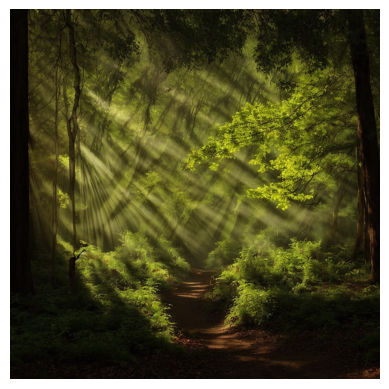

In [ ]:
# @title view

import matplotlib.pyplot as plt

# Mostrar la imagen generada
plt.imshow(output_image)
plt.axis('off')  # No mostrar los ejes
plt.show()